# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# План работы
- Изучить файлы с данными.
- Проверить данные на пропуски, дубликаты.
- Визуализировать данные.
- Провести предобработку данных.
- Определить целевой признак.
- Добавить признак Lifetime.
- Объединить таблицы, проверить данные на пропуски, дубликаты, корреляцию. 
- Визуализировать данные (долю пользователей телефонной связи, долю интернет-пользователей).
- Перевод категориальных признаков в численные - One-Hot-Encoding.
- Разбить данные на выборки: обучающую, тестовую.
- Борьба с дисбалансом.
- Обучить разные модели.
- Проанализировать скорость работы и качество моделей (Roc-AUC).

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def check(data):
    data.info()
    nan_perc = data.isna().sum() / data.shape[0] * 100
    print()
    print('Индекс упорядочен:',data.index.is_monotonic)
    print('Кол-во дубликатов -',data.duplicated().sum())
    print()
    print('\033[1mКол-во пропусков:\033[0m')
    print(data.isna().sum())
    print()
    print('\033[1mПроцент пропусков:\033[0m')
    print(nan_perc.sort_values(ascending=False))
    print('---------------------------')
    for column in data.columns:
        print()
        print('\033[1mCтолбец\033[0m', column)
        print('Кол-во уникальных значений -',data[column].nunique())
        print('Кол-во пропусков -',data[column].isnull().sum())
        print('Кол-во дубликатов -', data[column].duplicated().sum())
        print()
        print(data[column].value_counts().head())
        print()

In [4]:
sns.set(palette='mako', context='talk',style='darkgrid')
def charts(data, column, title):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    plt.suptitle(title, fontsize = "xx-large")
    distplot = sns.distplot(data[column],ax=axs[0])
    sns.boxplot(data[column], ax=axs[1])

In [5]:
def bar(data, column, title):
    plt.suptitle(title, fontsize = "xx-large")
    data[column].value_counts().plot(kind='bar',grid=True,figsize=(10,5))

### Contract - информация о договоре

In [6]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [7]:
check(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Процент пропусков:
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Type                0.0
EndDate             0.0
BeginDate           0.0
customerID          0.0
dtype: float64
---------------------------



In [8]:
contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [9]:
print('MonthlyCharges median:',contract['MonthlyCharges'].median())

MonthlyCharges median: 70.35


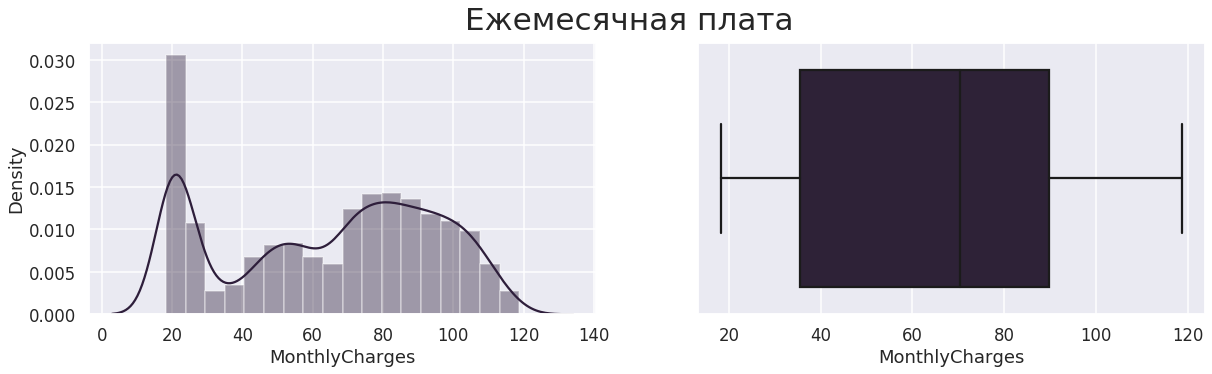

In [10]:
charts(contract, 'MonthlyCharges', 'Ежемесячная плата')

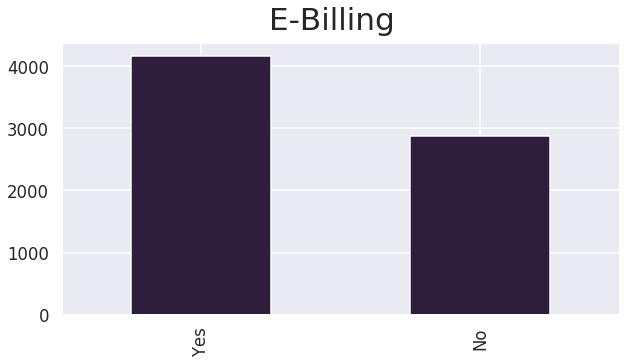

In [11]:
bar(contract, 'PaperlessBilling', 'E-Billing')

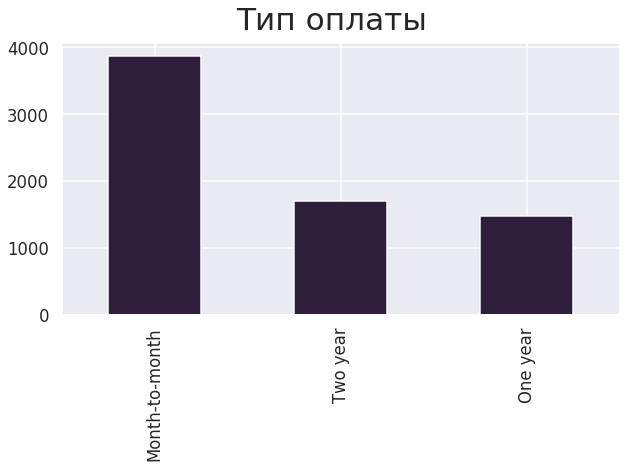

In [12]:
bar(contract, 'Type', 'Тип оплаты')

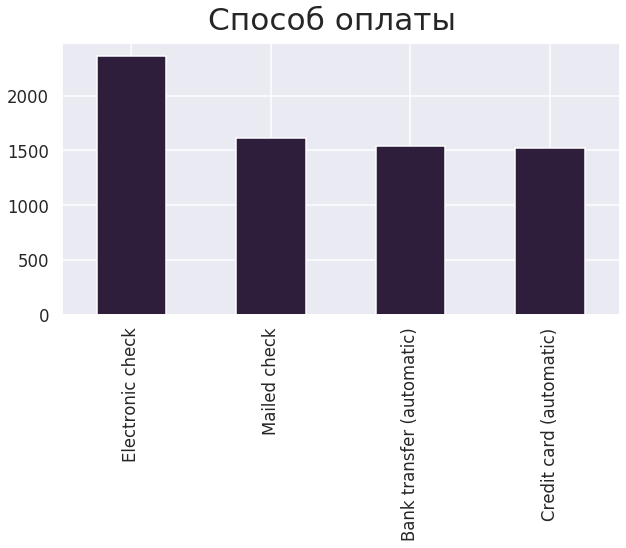

In [13]:
bar(contract, 'PaymentMethod', 'Способ оплаты')

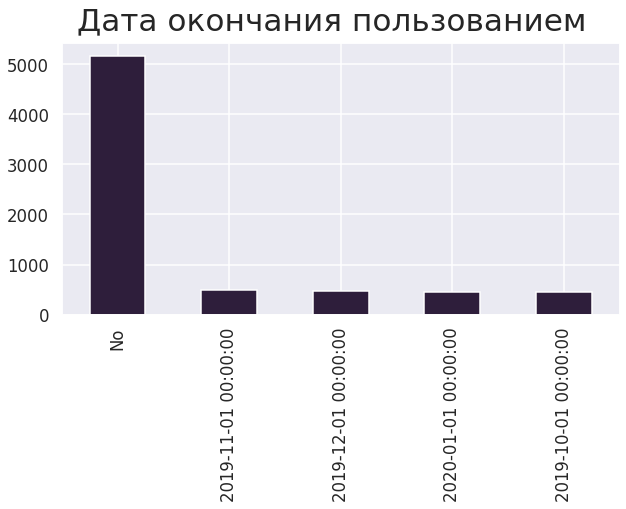

In [14]:
bar(contract, 'EndDate', 'Дата окончания пользованием')

**Промежуточный вывод:** 
- Пропуски и дубликаты отсутствуют.
- Заменить типы данных столбцов: BeginDate, EndDate, TotalCharges.
- Предварительно целевой признак EndDate: No — пользуется услугой.
- Посмотрели на графики bar, где имеется сильное различие в соотношении.
- Построили графики для столбца MonthlyCharges, распределение данных имеет скос вправо, что доказывают медиана 70.35 и среднее 64.76 — отрицательная асимметрия.

### Personal - персональные данные клиента

In [15]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [16]:
check(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Процент пропусков:
Dependents       0.0
Partner          0.0
SeniorCitizen    0.0
gender           0.0
customerID       0.0
dtype: float64
---------------------------

Cтолбец customerID
Кол-во уникальных значений - 7043
Кол-во пропусков - 0
Кол-во дубликатов - 0

4837-QUSFT    1
6967-QIQRV    1
9667-TKTVZ    1
0872-CASZJ    1
2001-EWBQU    1
Name: customerID, dtype: int64


Cтолбец gender
Кол-во уникальных значений - 2
Кол-во пропусков - 0
Кол-во дубликатов - 7041

Male   

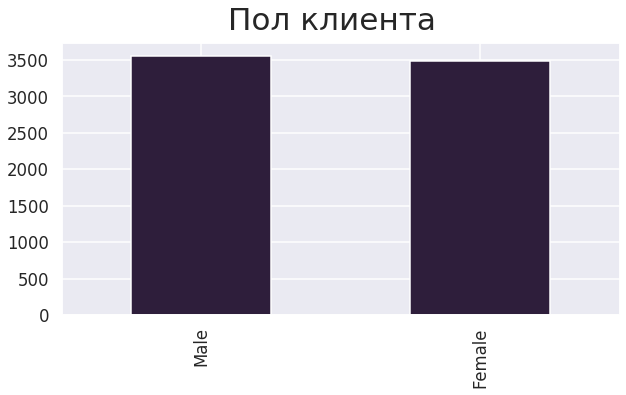

In [17]:
bar(personal, 'gender', 'Пол клиента')

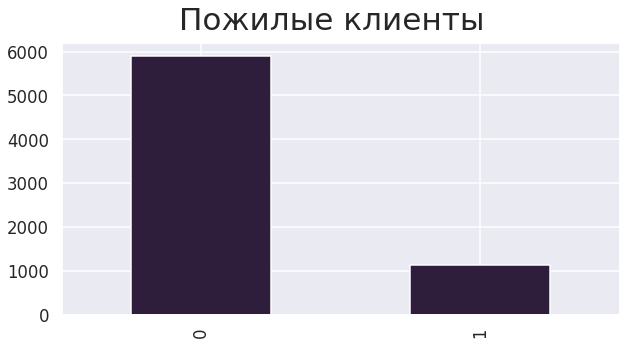

In [18]:
bar(personal, 'SeniorCitizen', 'Пожилые клиенты')

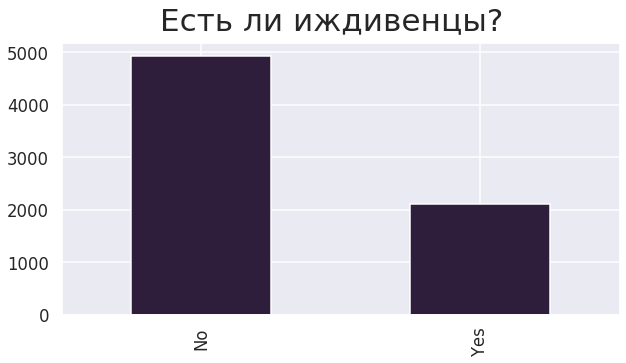

In [19]:
bar(personal, 'Dependents', 'Есть ли иждивенцы?')

**Промежуточный вывод:** 
- Пропуски и дубликаты отсутствуют.
- Посмотрели на графики bar, где визуализации соотношений.
- Женщин и мужчин примерно равное количество.
- Пожилых пользователей — 15%.

### Internet - информация об интернет-услугах

In [26]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [27]:
check(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Процент пропусков:
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
customerID          0.0
dtype: float64
---------------------------

Cтолбец custo

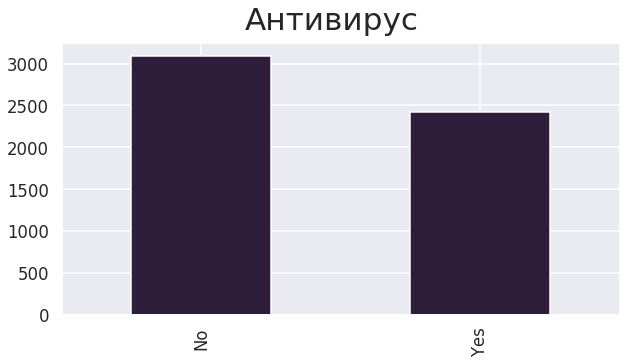

In [28]:
bar(internet,'DeviceProtection', 'Антивирус')

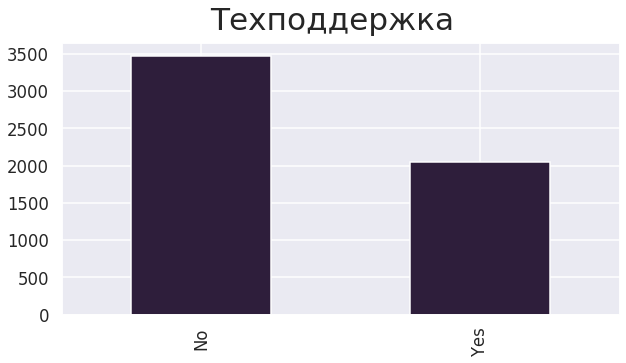

In [29]:
bar(internet, 'TechSupport', 'Техподдержка')

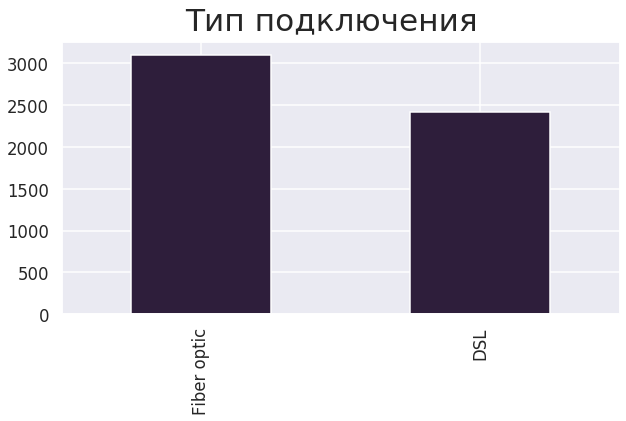

In [30]:
bar(internet, 'InternetService', 'Тип подключения')

**Промежуточный вывод:** 
- Пропуски и дубликаты отсутствуют.
- Посмотрели на графики bar, где визуализации соотношений.

### Phone - информация об услугах телефонии

In [31]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [32]:
check(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
customerID       0
MultipleLines    0
dtype: int64

Процент пропусков:
MultipleLines    0.0
customerID       0.0
dtype: float64
---------------------------

Cтолбец customerID
Кол-во уникальных значений - 6361
Кол-во пропусков - 0
Кол-во дубликатов - 0

9617-UDPEU    1
2886-KEFUM    1
6664-FPDAC    1
9297-FVVDH    1
4959-JOSRX    1
Name: customerID, dtype: int64


Cтолбец MultipleLines
Кол-во уникальных значений - 2
Кол-во пропусков - 0
Кол-во дубликатов - 6359

No     3390
Yes    2971
Name: MultipleLines, dtype: int64



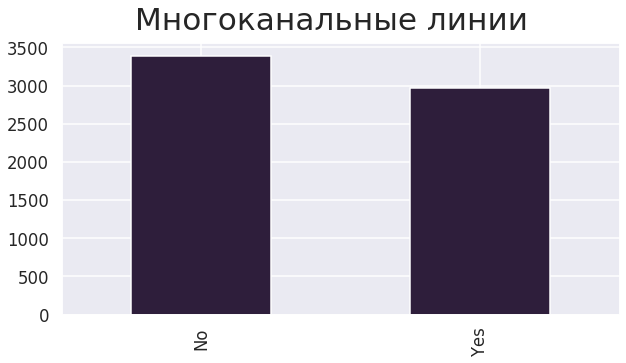

In [33]:
bar(phone, 'MultipleLines', 'Многоканальные линии')

**Промежуточный вывод:**
- Пропуски и дубликаты отсутствуют.
- Посмотрели на графики bar, где имеется сильное различие в соотношении.

### Выводы

Изучили 4 таблицы. Пропуски и дубликаты в них отсутствуют. Проведем предобработку и соединим их в одну.
За целевой признак возьмем данные на основании столбца EndDate, приведем данные к Yes/1(не пользуется) и No/0 (пользуется).
Так как большинство столбцов имеют категориальные значения, при подготовке к обучению моделей применим — One-Hot-Encoding.

## Target - Целевой признак

Создадим целевой признак Exited на основании данных столбца EndDate. Ноль будет означать, что клиент продолжает пользоваться услугами, единица, что отказался от услуг.

In [34]:
contract['Exited'] = (contract['EndDate'] != 'No').astype(int)

In [35]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


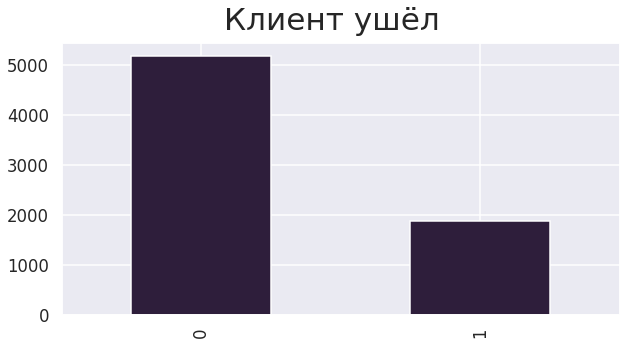

In [36]:
bar(contract, 'Exited', 'Клиент ушёл')

**Промежуточные выводы**: Имеется дисбаланс в целевом признаке, перед обученим моделей будем применять upsampling.

## Типы данных

In [37]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format = '%Y-%m-%d')

contract['EndDate'] = contract['EndDate'].replace(['No'], ['2020-02-01'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format = '%Y-%m-%d', errors='coerce')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors ='coerce')

In [38]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Exited              7043 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


**Промежуточные выводы:** После смены типа данных в столбце TotalCharges возникли пропуски. Их небольшое кол-во, посмотрим на них и решим чем их заполним.

In [33]:
contract[contract['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0


In [39]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Exited              7043 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


**Промежуточные выводы:** Пропусками оказались наши новички, которые только-только присоедились к нашей компании BeginDate и EndDate совпадают. Заполнили пропуски нулями.

## Единая таблица

### Lifetime клиентов

In [40]:
contract['Lifetime'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [41]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Lifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


### Соединяем

In [42]:
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')

In [43]:
check(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Exited              7043 non-null int64
Lifetime            7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines    

**Промежуточные выводы:** Как мы уже знаем, не у все пользователи пользуются одними и темиже услугами, поэтому при объединении возникли пропуски. Заменим их на No, что будет означать, что услуга не подключена.

In [44]:
for column in('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
              'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    data[column] = data[column].fillna('No')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Exited              7043 non-null int64
Lifetime            7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines    

### Исследовательский анализ

In [46]:
data.describe()

,MonthlyCharges,TotalCharges,Exited,Lifetime,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,985.996166,0.162147
std,30.090047,2266.794470,0.441561,747.587844,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


In [47]:
print('MonthlyCharges - median:', data['MonthlyCharges'].median())
print('TotalCharges - median:', data['TotalCharges'].median())

MonthlyCharges - median: 70.35
TotalCharges - median: 1394.55


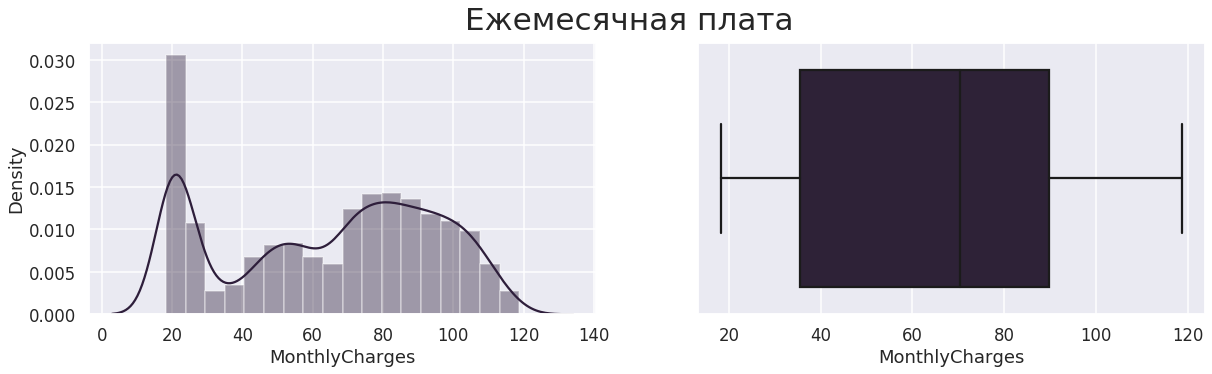

In [48]:
charts(data, 'MonthlyCharges','Ежемесячная плата')

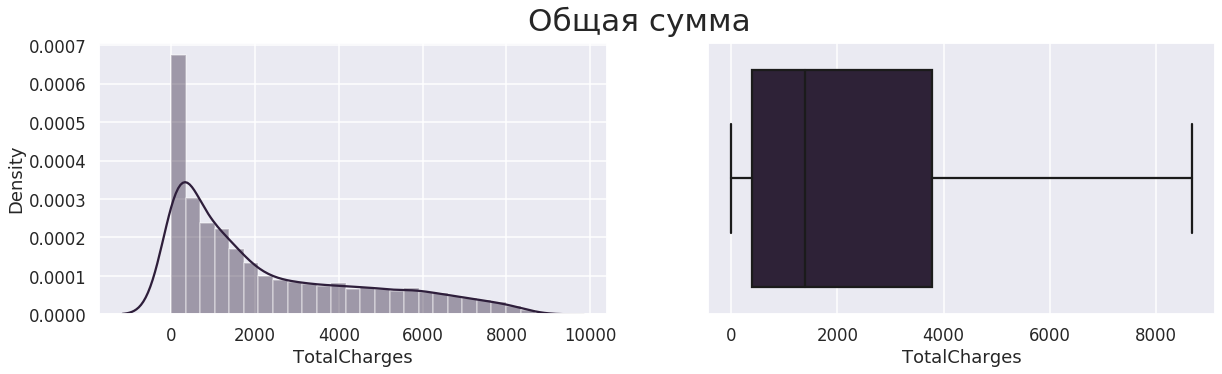

In [49]:
charts(data, 'TotalCharges','Общая сумма')

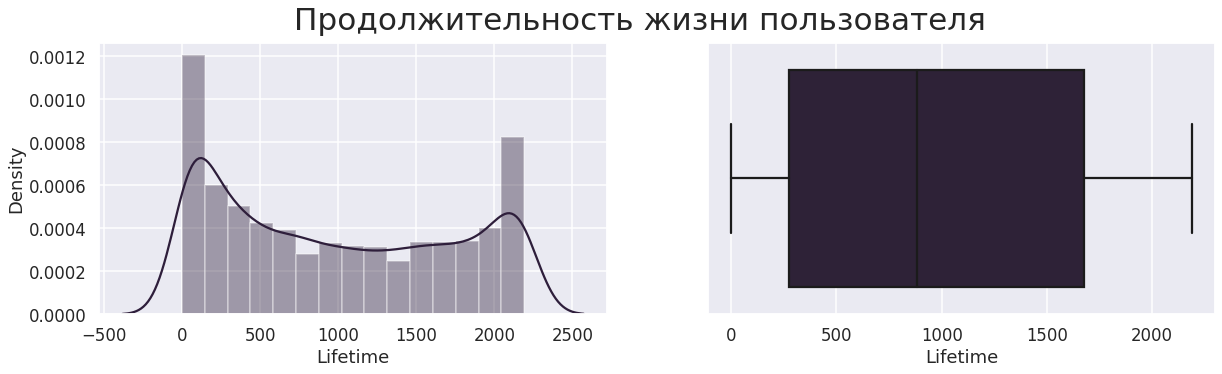

In [50]:
charts(data, 'Lifetime', 'Продолжительность жизни пользователя')

**Промежуточные выводы:** Наблюдаем бимодальное распределение в Lifetime. В случае MonthlyCharges имеем мультимодальность.

### Анализ клиентов

In [51]:
left = data[data['Exited'] == 1]
stay = data[data['Exited'] == 0]

In [52]:
def histogram(column, title):
    plt.figure(figsize=(12,5))
    plt.title(title, fontsize=15)
    plt.xlabel(['column'],fontsize='10')
    plt.ylabel("Частотность",fontsize='10')
    sns.distplot(left[column], label='Left', kde=False)
    sns.distplot(stay[column], label='Stay', kde=False)
    plt.axvline(np.median(left[column]),color='black', linestyle=':', label='Left медиана')
    plt.axvline(np.median(stay[column]),color='black', linestyle='-', label='Stay медиана')
    plt.legend()

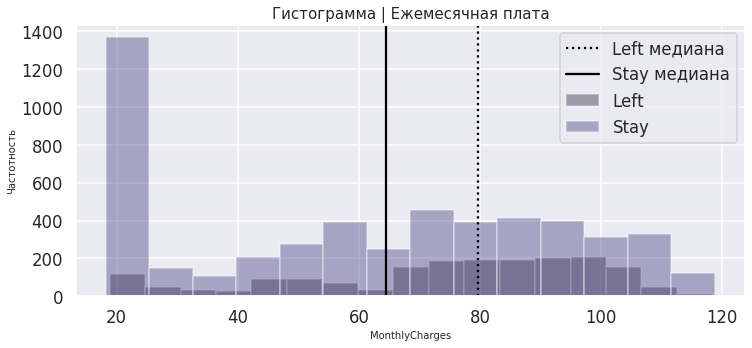

In [53]:
histogram('MonthlyCharges', 'Гистограмма | Ежемесячная плата')

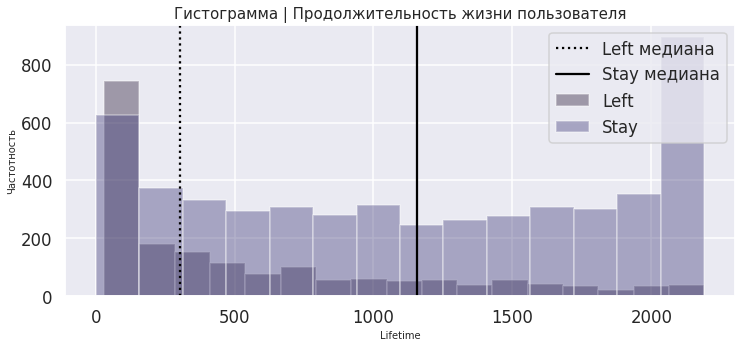

In [54]:
histogram('Lifetime', 'Гистограмма | Продолжительность жизни пользователя')

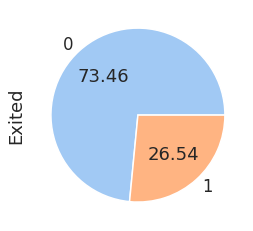

In [55]:
colors = sns.color_palette('pastel')[0:5]
data['Exited'].value_counts().plot(kind="pie", colors=colors, autopct="%.2F")
plt.show()

#### Ушедшие клиенты

In [56]:
left.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Lifetime,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,DSL,Yes,Yes,No,No,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,1,245,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,1,853,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
13,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,1491,...,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


In [57]:
left.describe().T.head(4)

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,1869.0,74.441332,24.666053,18.85,56.15,79.65,94.2,118.35
TotalCharges,1869.0,1531.796094,1890.822994,18.85,134.50,703.55,2331.3,8684.80
Exited,1869.0,1.000000,0.000000,1.00,1.00,1.00,1.0,1.00
Lifetime,1869.0,547.352060,594.389607,30.00,61.00,304.00,883.0,2191.00


In [58]:
print('MonthlyCharges - median:', left['MonthlyCharges'].median())
print('TotalCharges - median:', left['TotalCharges'].median())
print('Lifetime - median:', left['Lifetime'].median())

MonthlyCharges - median: 79.65
TotalCharges - median: 703.55
Lifetime - median: 304.0


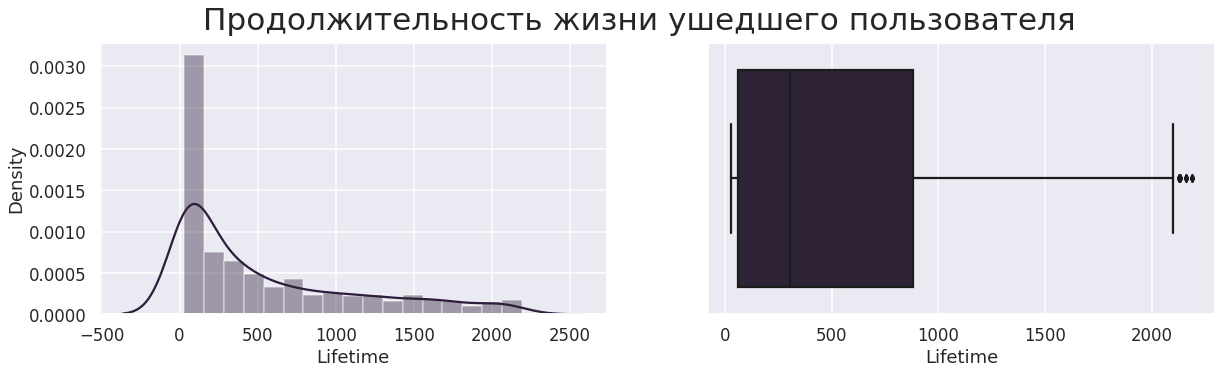

In [59]:
charts(left, 'Lifetime','Продолжительность жизни ушедшего пользователя')

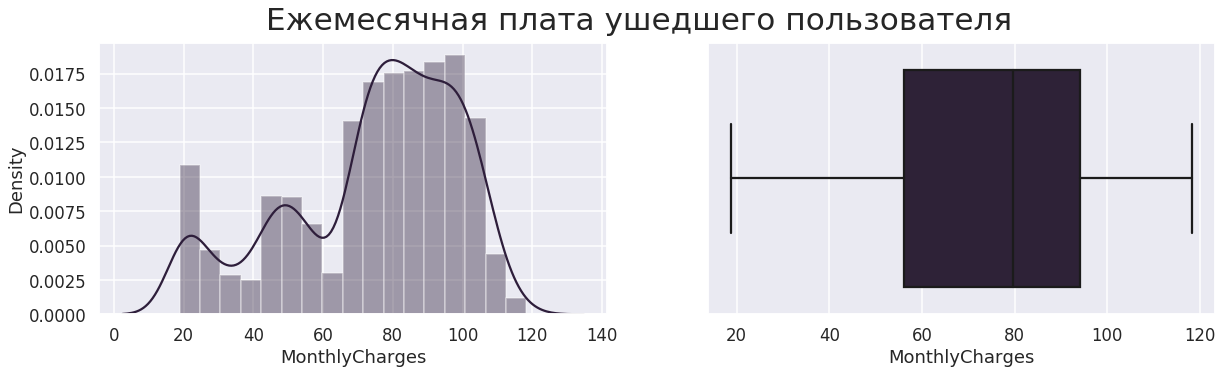

In [60]:
charts(left, 'MonthlyCharges', 'Ежемесячная плата ушедшего пользователя')

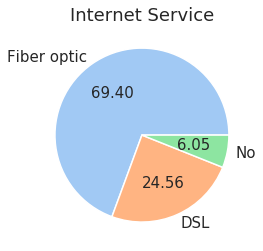

In [61]:
left['InternetService'].value_counts().plot(kind="pie", colors=colors, autopct='%.2F', label='',title='Internet Service', fontsize=15)
plt.show()

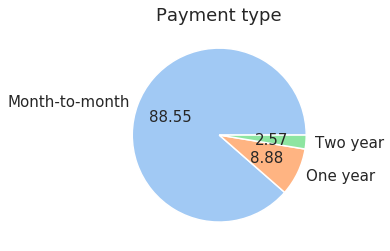

In [62]:
left['Type'].value_counts().plot(kind="pie", colors=colors, autopct='%.2F', label='',title='Payment type', fontsize=15)
plt.show()

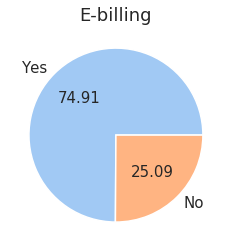

In [63]:
left['PaperlessBilling'].value_counts().plot(kind="pie", colors=colors, autopct='%.2F', label='',title='E-billing', fontsize=15)
plt.show()

#### Оставшиеся клиенты

In [64]:
stay.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Lifetime,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,No
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,671,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,0,306,...,No,No,DSL,Yes,No,No,No,No,No,No


In [65]:
stay.describe().T.head(4)

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,5174.0,61.265124,31.092648,18.25,25.1,64.425,88.40,118.75
TotalCharges,5174.0,2549.911442,2329.954215,0.00,572.9,1679.525,4262.85,8672.45
Exited,5174.0,0.000000,0.000000,0.00,0.0,0.000,0.00,0.00
Lifetime,5174.0,1144.447236,733.897937,0.00,457.0,1157.000,1857.00,2191.00


In [66]:
print('MonthlyCharges - median:', stay['MonthlyCharges'].median())
print('TotalCharges - median:', stay['TotalCharges'].median())
print('Lifetime - median:', stay['Lifetime'].median())

MonthlyCharges - median: 64.42500000000001
TotalCharges - median: 1679.525
Lifetime - median: 1157.0


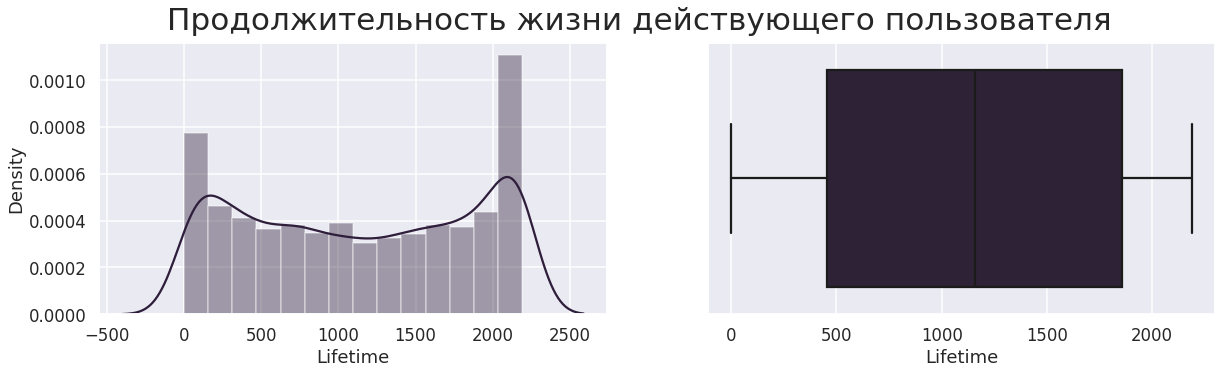

In [67]:
charts(stay, 'Lifetime', 'Продолжительность жизни действующего пользователя')

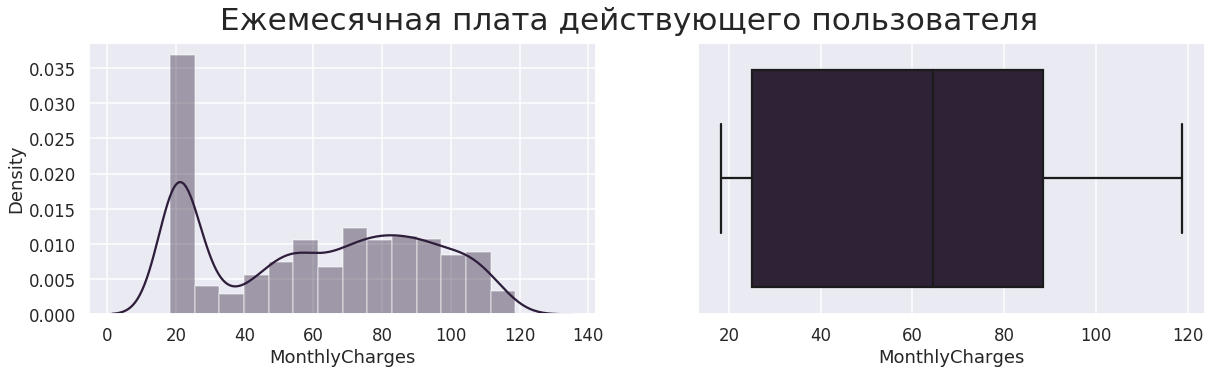

In [68]:
charts(stay, 'MonthlyCharges','Ежемесячная плата действующего пользователя')

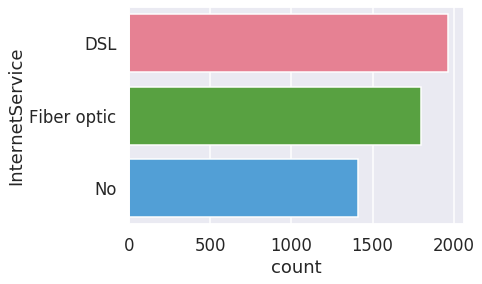

In [69]:
sns.countplot(y='InternetService', data=stay, palette="husl")
plt.show()

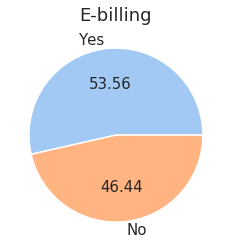

In [70]:
stay['PaperlessBilling'].value_counts().plot(kind="pie", colors=colors, autopct='%.2F', label='',title='E-billing', fontsize=15)
plt.show()

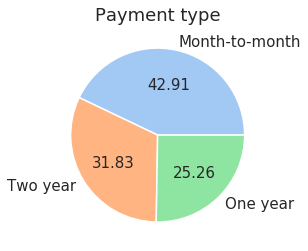

In [71]:
stay['Type'].value_counts().plot(kind="pie", colors=colors, autopct='%.2F', label='',title='Payment type', fontsize=15)
plt.show()

#### Выводы

Сравнили распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл. Для каждой группы посчитайте статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.
У нас на 01.02.2020 процент оттока клиентов составляет 26%.
Стоит отметить, что клиенты, которые уходя платят больше в месяц, чем клиенты, которые остаются. 

Mедианные значения ушедших клиентов:
- Lifetime - 304.0
- MonthlyCharges - 79.65

Интересно отметить, что большинство ушедших клиентов (около 70%) пользовались интернет подключением Fiber optic (оптоволоконный кабель). В то время, как оставшиеся клиенты по преимуществу имеют DSL подключение (digital subscriber line - ‘цифровая абонентская линия’). 
Также, стоит отметить, что 88% ушедших пользовались помесячной оплатой услуг, а оставшиеся клиенты имеют более равномерное распределение.

Медианные значения оставшихся клиентов:
- Lifetime - 1157.0
- MonthlyCharges - 64.42

### Корреляция

In [72]:
data.corr()

,MonthlyCharges,TotalCharges,Exited,Lifetime,SeniorCitizen
MonthlyCharges,1.000000,0.651174,0.193356,0.247754,0.220173
TotalCharges,0.651174,1.000000,-0.198324,0.826109,0.103006
Exited,0.193356,-0.198324,1.000000,-0.352673,0.150889
Lifetime,0.247754,0.826109,-0.352673,1.000000,0.016514
SeniorCitizen,0.220173,0.103006,0.150889,0.016514,1.000000


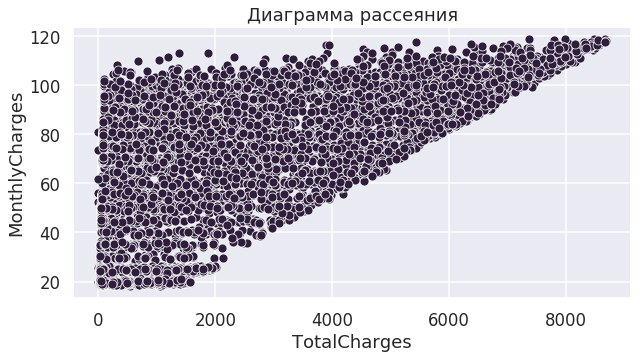

In [73]:
plt.figure(figsize=(10,5))
plt.title('Диаграмма рассеяния')
sns.scatterplot(data=data, x='TotalCharges', y='MonthlyCharges')

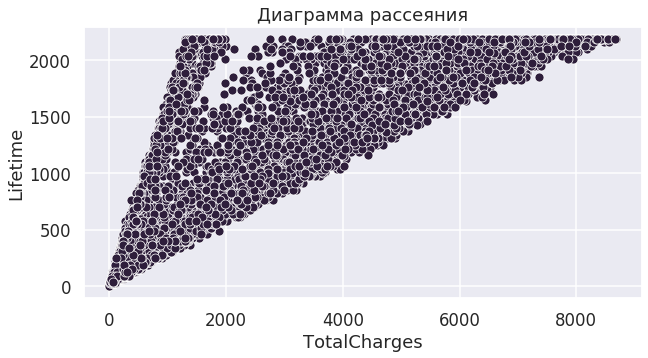

In [74]:
plt.figure(figsize=(10,5))
plt.title('Диаграмма рассеяния')
sns.scatterplot(data=data, x='TotalCharges', y='Lifetime')

**Промежуточные выводы:** Столбец TotalCharges имеет среднюю (0.65) и высокую(0.82) корреляции со столбцами MonthlyCharges и Lifetime. Удалим его.

## Подготовка к обучению

Удалим не нужные столбцы, проведем One-Hot Encoding.

In [75]:
del data['BeginDate'], data['EndDate'], data['TotalCharges']

In [76]:
numeric_columns = ['MonthlyCharges', 'Lifetime']

In [77]:
data = data.set_index('customerID')

In [78]:
data = pd.get_dummies(data, drop_first=True)

In [79]:
data.head()

,MonthlyCharges,Exited,Lifetime,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0,31,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,0,1036,0,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,1,61,0,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,0,1371,0,1,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,1,61,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


### Признаки и выборки

In [80]:
features = data.drop('Exited', axis=1) 
target = data['Exited']

In [81]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [82]:
print('Train shape:', features_train.shape)
print('Test shape:', features_test.shape)

Train shape: (5634, 21)
Test shape: (1409, 21)


### Борьба с дисбалансом

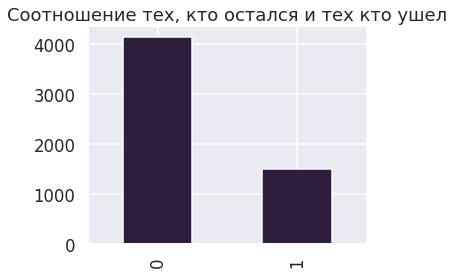

In [83]:
target_train.value_counts().plot(kind='bar',grid=True,figsize=(5,4), title='Соотношение тех, кто остался и тех кто ушел')
plt.show()

In [84]:
scaler=StandardScaler()
scaler.fit(features_train[numeric_columns])

features_train[numeric_columns]=scaler.transform(features_train[numeric_columns])
features_test[numeric_columns]=scaler.transform(features_test[numeric_columns])

In [85]:
def upsampling(features,target,repeat):
    target_one=target[target==1]
    target_null=target[target==0]
    features_one=features[target==1]
    features_null=features[target==0]
    
    features_upsampled = pd.concat([features_null]+[features_one]*repeat)
    target_upsampled = pd.concat([target_null]+[target_one]*repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=123456)
    
    return features_upsampled, target_upsampled

In [86]:
features_train, target_train = upsampling(features_train, target_train, 2)

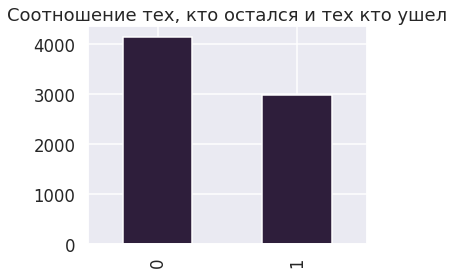

In [87]:
target_train.value_counts().plot(kind='bar',grid=True,figsize=(5,4), title='Соотношение тех, кто остался и тех кто ушел')
plt.show()

## Обучение моделей

In [88]:
model_1 = LogisticRegression()
model_2 = RandomForestClassifier(random_state=12345)
model_3 = DecisionTreeClassifier(random_state=12345)

param_LR = {'C': [0.01, 0.1, 1, 10, 100], 'solver' : ['liblinear', 'lbfgs']}
param_RF = {'n_estimators':[5,100],
             'max_depth':[1,10], 'min_samples_split': [2, 3]}
param_DT= {'max_depth':[1,10], 'splitter':('best','random'), 'min_samples_split':np.arange(2,10)}

LR = GridSearchCV(model_1 ,param_grid = param_LR, cv=5, scoring='roc_auc')
RF = GridSearchCV(model_2,param_grid = param_RF, cv=5, scoring='roc_auc')
DT = GridSearchCV(model_3,param_grid = param_DT, cv=5, scoring='roc_auc')

### Логистическая регрессия

In [89]:
%%time
#Logistic regression
start_1 = time.time()
LR.fit(features_train, target_train)
end_1 = time.time()
fit_LR = end_1 - start_1

start_2 = time.time()
prediction_LR = LR.predict(features_test)
end_2 = time.time()
pred_LR = end_2 - start_2

pre_proba_LR = LR.predict_proba(features_test)[:,1]

roc_auc_LR_proba = roc_auc_score(target_test, pre_proba_LR)
accuracy_LR = accuracy_score(target_test, prediction_LR)


print('\n========================================================')
print('Logistic регрессия')
print('========================================================')
print('ROC-AUC:', round(roc_auc_LR_proba, 4) )
print('Accuracy:', round(accuracy_LR, 4))
print('Время обучения:', round(fit_LR,4), 'vs', 'Время предсказания', round(pred_LR,4))
print()
print('Наилучшие гиперпараметры:',LR.best_params_)
print()


Logistic регрессия
ROC-AUC: 0.8437
Accuracy: 0.7764
Время обучения: 29.0003 vs Время предсказания 0.005

Наилучшие гиперпараметры: {'C': 10, 'solver': 'lbfgs'}

CPU times: user 10.5 s, sys: 13.6 s, total: 24.1 s
Wall time: 29.1 s


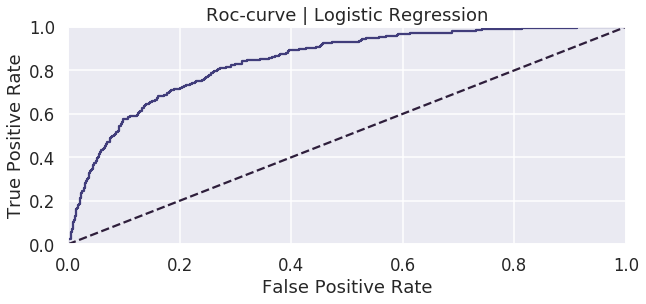

AUC-ROC: 0.8437


In [90]:
fpr, tpr, thresholds = roc_curve(target_test, pre_proba_LR)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | Logistic Regression')
plt.show()

print('AUC-ROC:', round(roc_auc_LR_proba, 4))

### Случайный лес

In [91]:
%%time
#Random Forest
start_1 = time.time()
RF.fit(features_train, target_train)
end_1 = time.time()
fit_RF = end_1 - start_1

start_2 = time.time()
prediction_RF = RF.predict(features_test)
end_2 = time.time()
pred_RF = end_2 - start_2

pre_proba_RF = RF.predict_proba(features_test)[:,1]

roc_auc_RF_proba = roc_auc_score(target_test, pre_proba_RF)
accuracy_RF = accuracy_score(target_test, prediction_RF)


print('\n========================================================')
print('Random Forest')
print('========================================================')
print('ROC-AUC:', round(roc_auc_RF_proba, 4) )
print('Accuracy:', round(accuracy_RF, 4))
print('Время обучения:', round(fit_RF,4), 'vs', 'Время предсказания', round(pred_RF,4))
print()
print('Наилучшие гиперпараметры:',RF.best_params_)
print()


Random Forest
ROC-AUC: 0.8576
Accuracy: 0.7984
Время обучения: 23.1689 vs Время предсказания 0.0279

Наилучшие гиперпараметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

CPU times: user 9.68 s, sys: 0 ns, total: 9.68 s
Wall time: 23.3 s


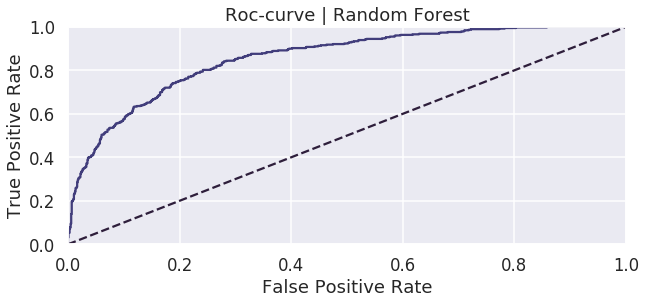

AUC-ROC: 0.8576


In [92]:
fpr, tpr, thresholds = roc_curve(target_test, pre_proba_RF)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | Random Forest')
plt.show()

print('AUC-ROC:', round(roc_auc_RF_proba, 4))

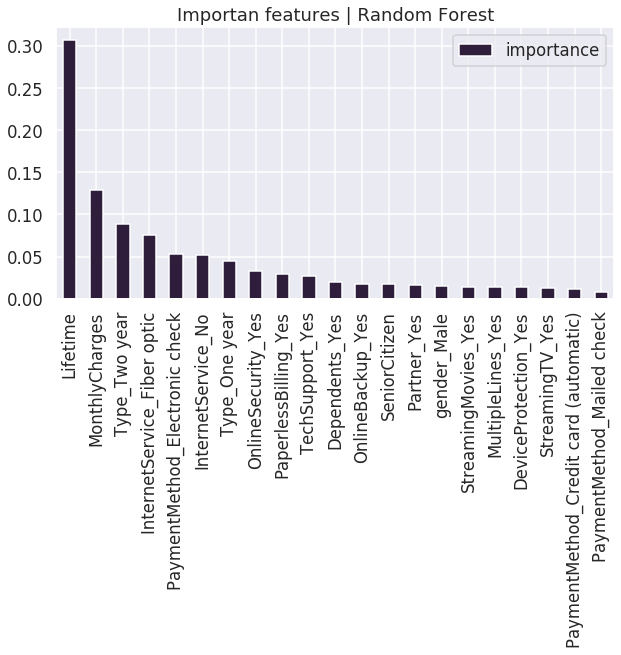

In [93]:
imp = pd.DataFrame(RF.best_estimator_.feature_importances_, index = features_test.columns, columns=['importance'])
imp = imp.sort_values(by='importance', ascending=False).plot(kind='bar', figsize=(10, 5), title='Importan features | Random Forest')

### Древо решений

In [94]:
%%time
#DecisionTree
start_1 = time.time()
DT.fit(features_train, target_train)
end_1 = time.time()
fit_DT = end_1 - start_1

start_2 = time.time()
prediction_DT = DT.predict(features_test)
end_2 = time.time()
pred_DT = end_2 - start_2

pre_proba_DT = DT.predict_proba(features_test)[:,1]

roc_auc_DT_proba = roc_auc_score(target_test, pre_proba_DT)
accuracy_DT = accuracy_score(target_test, prediction_DT)


print('\n========================================================')
print('Decision Tree')
print('========================================================')
print('ROC-AUC:', round(roc_auc_DT_proba, 4) )
print('Accuracy:', round(accuracy_DT, 4))
print('Время обучения:', round(fit_DT,4), 'vs', 'Время предсказания', round(pred_DT,4))
print()
print('Наилучшие гиперпараметры:',DT.best_params_)
print()


Decision Tree
ROC-AUC: 0.8213
Accuracy: 0.8006
Время обучения: 6.0193 vs Время предсказания 0.0012

Наилучшие гиперпараметры: {'max_depth': 10, 'min_samples_split': 2, 'splitter': 'best'}

CPU times: user 2.5 s, sys: 0 ns, total: 2.5 s
Wall time: 6.03 s


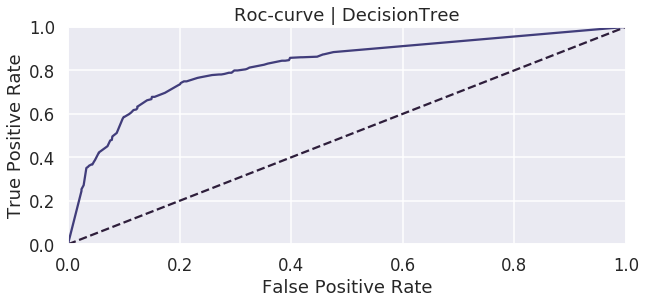

AUC-ROC: 0.8213


In [95]:
fpr, tpr, thresholds = roc_curve(target_test, pre_proba_DT)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | DecisionTree')
plt.show()

print('AUC-ROC:', round(roc_auc_DT_proba, 4))

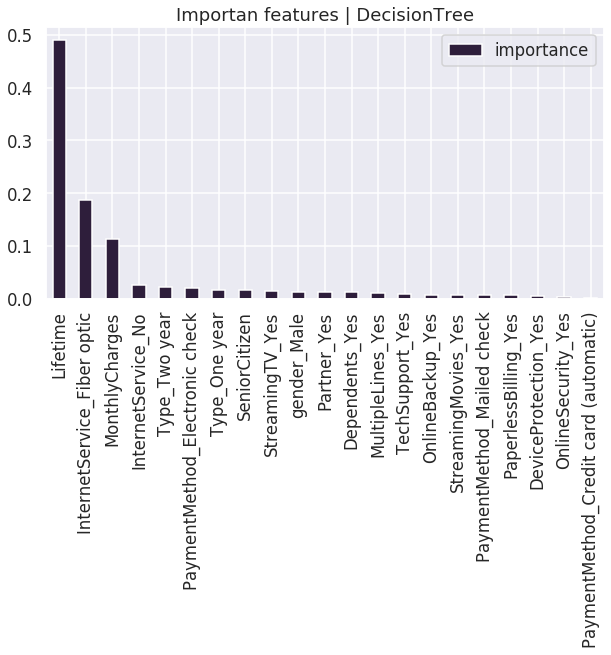

In [96]:
imp = pd.DataFrame(DT.best_estimator_.feature_importances_, index = features_test.columns, columns=['importance'])
imp = imp.sort_values(by='importance', ascending=False).plot(kind='bar', figsize=(10, 5), title='Importan features | DecisionTree')

### CatBoost

In [97]:
param = {'learning_rate': [0.1, 0.3]}

model = CatBoostClassifier(random_state=12345, iterations=100)

cat = GridSearchCV(model, param_grid = param, cv=5, scoring='roc_auc')

In [98]:
%%time
start_1 = time.time()
cat.fit(features_train, target_train,eval_set=[(features_test, target_test),], verbose = 100)
end_1 = time.time()
fit_cat = end_1 - start_1

start_2 = time.time()
prediction_cat = cat.predict(features_test)
end_2 = time.time()
pred_cat = end_2 - start_2

pre_proba_cat = cat.predict_proba(features_test)[:,1]

roc_auc_cat_proba = roc_auc_score(target_test, pre_proba_cat)
accuracy_cat = accuracy_score(target_test, prediction_cat)
   
print("\n========================================================")
print("CatBoost" )
print("========================================================")
print('Roc-AUC:', round(roc_auc_cat_proba, 4))
print('Accuracy:', round(accuracy_cat, 4))
print('Время обучения:', round(fit_cat,4), 'vs', 'Время предсказания:', round(pred_cat,4))
print('Наилучшие гиперпараметры:', cat.best_params_)
print()

0:	learn: 0.6543242	test: 0.6508933	best: 0.6508933 (0)	total: 59.5ms	remaining: 5.89s
99:	learn: 0.3356156	test: 0.4049938	best: 0.4049938 (99)	total: 6.09s	remaining: 0us

bestTest = 0.4049937643
bestIteration = 99

0:	learn: 0.6412650	test: 0.6383124	best: 0.6383124 (0)	total: 13.1ms	remaining: 1.3s
99:	learn: 0.3373838	test: 0.3977844	best: 0.3977844 (99)	total: 5.66s	remaining: 0us

bestTest = 0.3977844093
bestIteration = 99

0:	learn: 0.6416219	test: 0.6383703	best: 0.6383703 (0)	total: 65.6ms	remaining: 6.5s
99:	learn: 0.3402961	test: 0.3960867	best: 0.3960867 (99)	total: 6.43s	remaining: 0us

bestTest = 0.3960867451
bestIteration = 99

0:	learn: 0.6416508	test: 0.6384509	best: 0.6384509 (0)	total: 11.5ms	remaining: 1.14s
99:	learn: 0.3409450	test: 0.3971576	best: 0.3971576 (99)	total: 7.13s	remaining: 0us

bestTest = 0.3971575821
bestIteration = 99

0:	learn: 0.6513934	test: 0.6474629	best: 0.6474629 (0)	total: 22.2ms	remaining: 2.2s
99:	learn: 0.3525543	test: 0.3900494	best: 0

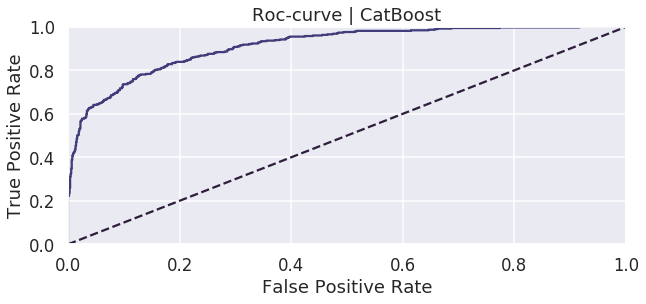

AUC-ROC: 0.9115


In [99]:
fpr, tpr, thresholds = roc_curve(target_test, pre_proba_cat)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | CatBoost')
plt.show()

print('AUC-ROC:', round(roc_auc_cat_proba, 4))

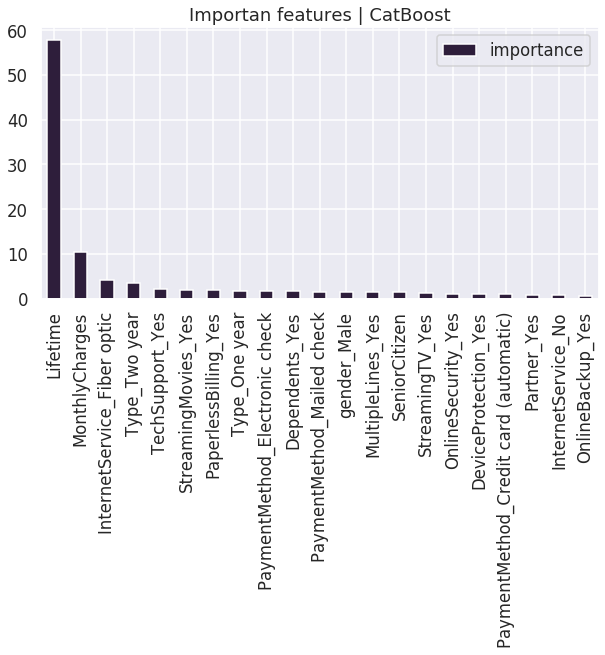

In [100]:
imp = pd.DataFrame(cat.best_estimator_.feature_importances_, index = features_test.columns, columns=['importance'])
imp = imp.sort_values(by='importance', ascending=False).plot(kind='bar', figsize=(10, 5), title='Importan features | CatBoost')

### LGBMClassifier

In [101]:
param = {'learning_rate': [0.1, 0.3]}

model =  LGBMClassifier(random_state=12345, n_estimators=100)

lgbm = GridSearchCV(model, param_grid = param, cv=5, scoring='roc_auc')

In [102]:
%%time

start_1 = time.time()
lgbm.fit(features_train, target_train, verbose = 100, eval_set=[(features_test, target_test),])
end_1 = time.time()
fit_lgbm = end_1 - start_1

start_2 = time.time()
prediction_lgbm = lgbm.predict(features_test)
end_2 = time.time()
pred_lgbm = end_2 - start_2

pre_proba_lgbm = lgbm.predict_proba(features_test)[:,1]

roc_auc_lgbm_proba = roc_auc_score(target_test, pre_proba_lgbm)
accuracy_lgbm = accuracy_score(target_test, prediction_lgbm)

print("\n========================================================")
print("LGBMClassifier" )
print("========================================================")
print('ROC-AUC:', round(roc_auc_lgbm_proba, 4))
print('Accuracy:', round(accuracy_lgbm, 4))
print()
print('Время обучения:', round(fit_lgbm,4), 'vs', 'Время предсказания:', round(pred_lgbm,4))
print('Наилучшие гиперпараметры:', lgbm.best_params_)
print()

[100]	valid_0's binary_logloss: 0.367554
[100]	valid_0's binary_logloss: 0.352356
[100]	valid_0's binary_logloss: 0.357479
[100]	valid_0's binary_logloss: 0.365469
[100]	valid_0's binary_logloss: 0.359041
[100]	valid_0's binary_logloss: 0.366575
[100]	valid_0's binary_logloss: 0.359735
[100]	valid_0's binary_logloss: 0.361985
[100]	valid_0's binary_logloss: 0.372928
[100]	valid_0's binary_logloss: 0.375538
[100]	valid_0's binary_logloss: 0.338984

LGBMClassifier
ROC-AUC: 0.9106
Accuracy: 0.863

Время обучения: 3461.3816 vs Время предсказания: 0.0142
Наилучшие гиперпараметры: {'learning_rate': 0.3}

CPU times: user 42min 12s, sys: 16.5 s, total: 42min 28s
Wall time: 57min 41s


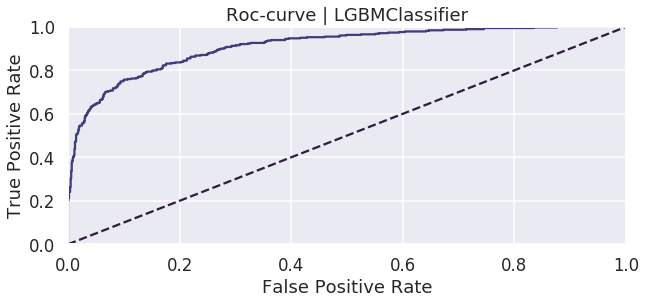

AUC-ROC: 0.9106


In [103]:
fpr, tpr, thresholds = roc_curve(target_test, pre_proba_lgbm)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | LGBMClassifier')
plt.show()

print('AUC-ROC:', round(roc_auc_lgbm_proba, 4))

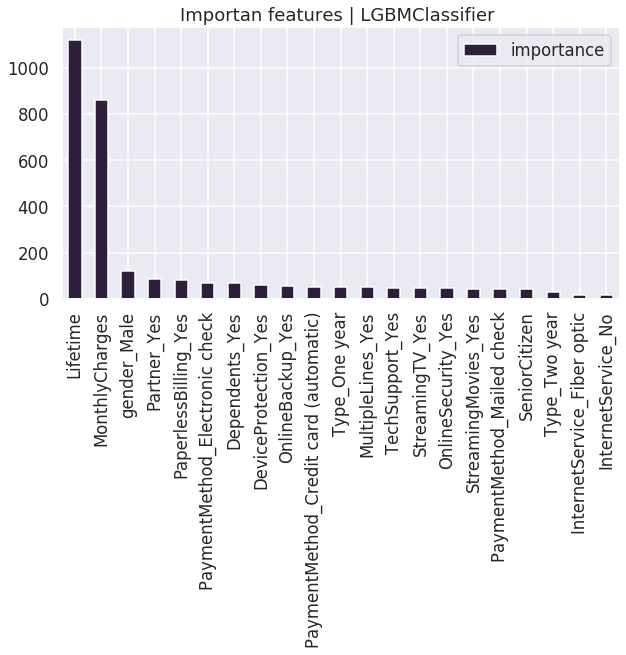

In [104]:
imp = pd.DataFrame(lgbm.best_estimator_.feature_importances_, index = features_test.columns, columns=['importance'])
imp = imp.sort_values(by='importance', ascending=False).plot(kind='bar', figsize=(10, 5), title='Importan features | LGBMClassifier ')

## Анализ моделей

По итогам исследования удалось установить, что важным признаками для предсказания оттока являются Lifetime и MonthlyCharges.

В ходе исследования обучили 5 моделей и для каждой попробовали различные гипепараметры. Расположим результаты полученных показателей от наилучшего к худшему.

**Базовые модели | ROC-AUC:**
- Случайный лес: 0.8576
- Logistic регрессия: 0.8437
- Древо решений: 0.8213

**Скорость обучения:**
- Древо решений: 1.9392
- Случайный лес: 6.3176
- Logistic регрессия: 18.316

**Скорость предсказания:**
- Древо решений: 0.0011
- Случайный лес: 0.0247
- Logistic регрессия: 0.0907


**Модели с градиентным бустингом | ROC-AUC:**
- CatBoost: 0.9115
- LightGBM: 0.9106

**Скорость обучения:**
- LightGBM: 19.6842
- CatBoost: 34.0686

**Скорость предсказания:**
- CatBoost: 0.007
- LightGBM: 0.0075

Итак, среди простых моделей оптимальным вариантом будет алгоритм Случайного Леса. У данного алгоритма среди простых моделей наилучший показатель Roc-Auc, но он уступает по скорости обучения и предсказанию алгоритму Древо решений. А что касается CatBoost и LightGBM, оба алгоритма показали отличные результаты с небольшой разницей в пользу LightGBM, так как он  быстрее обучается.
По итогом исследования из полученных результатов можно выделить следующие решения для заказчика:
- Если важна точность и неважна скорость обучения - CatBoost
- Если важна точность  и скорость обучения — LightGBM